In [1]:
from __future__ import print_function

import os
import torch
from cfgs.test_cfgs import TestOptions
from utils import model_utils
import cvp.vis as vis_utils
from cvp.logger import Logger
from cvp.losses import LossManager

torch.manual_seed(123)
    
args = TestOptions()

if not args.initialized:
    args.initialize() 
args.opt = args.parser.parse_args('')
os.environ['CUDA_VISIBLE_DEVICES'] = args.opt.gpu
args.opt = args.set_default_args(args.opt)
args = args.opt

# default
args.kl_loss_weight = 1e-2
args.l1_dst_loss_weight = 1.
args.bbox_loss_weight = 1.#100
args.l1_src_loss_weight = 1.

args.gpu = 1
args.dataset = 'vvn/collide2_new'
args.checkpoint = './output/tmp/vvn/collide2_newrgb_cvp_traj_comb_late_fact_gc_n2e2n_Ppix1_iter1000.pth'

args.dt = 10

In [2]:
from tqdm import tqdm
import numpy as np

data_loader = model_utils.build_loaders(args)  # change to image
print('data_loader loaded')
model = model_utils.build_all_model(args)  # CNN, GCN, Encoder, Decoder
print('model loaded')

val
data_loader loaded
Init... ./output/tmp/vvn/collide2_newrgb_cvp_traj_comb_late_fact_gc_n2e2n_Ppix1_iter1000.pth
model loaded


In [3]:
from PIL import Image
from tqdm import tqdm

offset = 50000
cnt = 0
batch_size = 20

data = [dict() for _ in range(batch_size)]
        
for batch in tqdm(data_loader):
    with torch.no_grad():
        #predictions = model.forward_inception(batch, args.dt)
        predictions = model.forward_with_reality(batch, 10)
        if cnt == 0:
            print(batch['image'].shape)
            print(predictions.keys())
            
        data[cnt]['predictions'] = predictions['bbox'].cpu().numpy().squeeze(1)
        images = []
        for i in range(4, 10):
            image_path = '/mnt/fs4/fanyun/cvp_stimulis/collide2_new/{}/rgb-cam_1-{:02d}.jpg'.format(offset+cnt, i)
            im = Image.open(image_path)
            images.append(np.array(im))
        data[cnt]['images'] = np.array(images)
        data[cnt]['labels'] = np.load('/mnt/fs4/fanyun/cvp_stimulis/collide2_new/{}/cam_1.npy'.format(offset+cnt))[4:, ...]

        cnt += 1
        if cnt >= batch_size:
            break

  0%|          | 1/1000 [00:06<1:44:45,  6.29s/it]

torch.Size([7, 1, 1, 3, 256, 256])
dict_keys(['appr', 'real_recon', 'pred_maskl', 'real_maskl', 'bbox', 'pred_recon'])


  2%|▏         | 19/1000 [01:50<1:35:10,  5.82s/it]


In [4]:
print(len(data))
print(data[0].keys())
print(data[0]['predictions'].shape)
print(data[0]['labels'].shape)
print(data[0]['images'].shape)

20
dict_keys(['images', 'predictions', 'labels'])
(6, 2, 2)
(6, 2, 2)
(6, 256, 256, 3)


In [5]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
from cv2 import VideoWriter, VideoWriter_fourcc
import numpy as np
import pickle

def draw_bounding_boxes(image, bboxes, color = [0, 255, 0]):
    color = np.array(color, dtype=np.uint8)
    for box in bboxes:
        box = np.round(box).astype(np.int32)
        
        box[1] = np.minimum(image.shape[0] - 1, np.maximum(0, box[1]))
        box[3] = np.minimum(image.shape[0] - 1, np.maximum(0, box[3]))
        box[0] = np.minimum(image.shape[1] - 1, np.maximum(0, box[0]))
        box[2] = np.minimum(image.shape[1] - 1, np.maximum(0, box[2]))
        
        image[box[1], box[0]:box[2]] = color
        image[box[1]:box[3], box[0]] = color
        image[box[3], box[0]:box[2]] = color
        image[box[1]:box[3], box[2]] = color
    return image

def draw_positions(image, positions, color = [255, 0, 0], size = 2):
    color = np.array(color, dtype=np.uint8)
    for pos in positions:
        pos = np.round(pos).astype(np.int32)
        
        pos[0] = np.minimum(image.shape[1] - 1, np.maximum(0, pos[0]))
        pos[1] = np.minimum(image.shape[0] - 1, np.maximum(1, pos[1]))
        
        #image[pos[1]-size:pos[1]+size, pos[0]-size:pos[0]+size] = color
        image[pos[0]-size:pos[0]+size, pos[1]-size:pos[1]+size] = color
    return image

def make_videos(images, video_file, FPS=20):
    fourcc = VideoWriter_fourcc(*'MP4V')
    extension = ".mp4"

    height = images.shape[-3]
    width = images.shape[-2]
    video_file = video_file + extension
    video = VideoWriter(video_file, fourcc, float(FPS), (width, height))
    for tidx, time_images in enumerate(images):
        video.write(time_images)
    video.release()

(6, 2, 2)
(6, 2, 2)
6


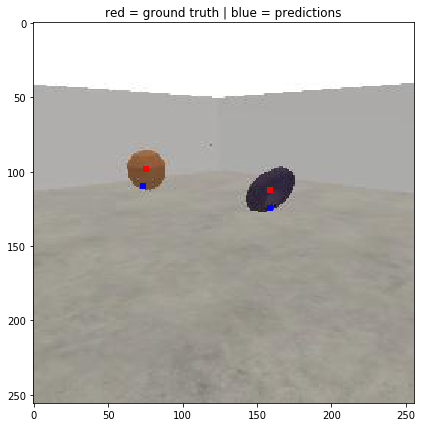

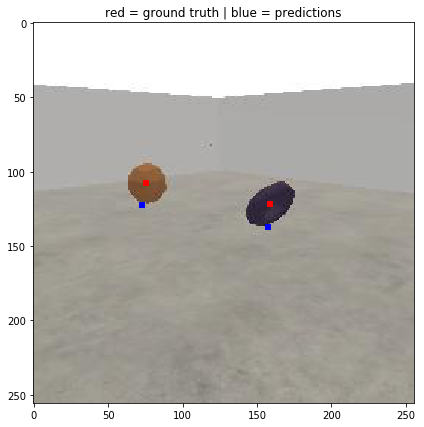

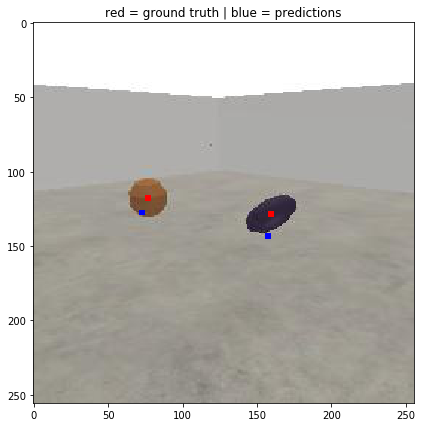

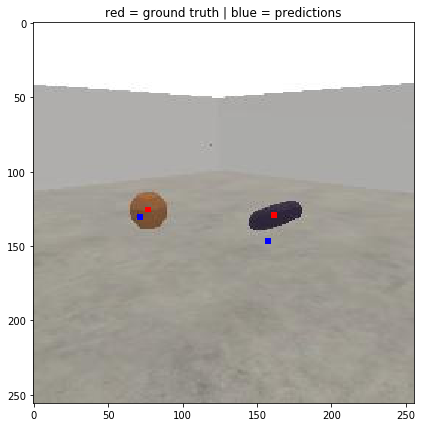

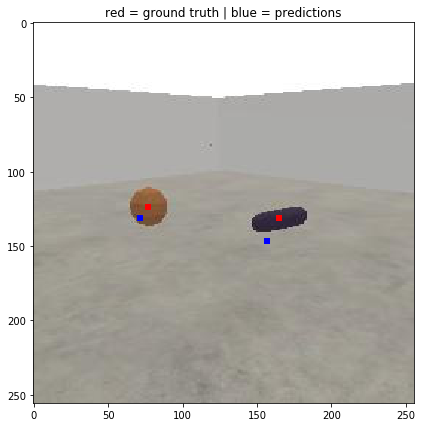

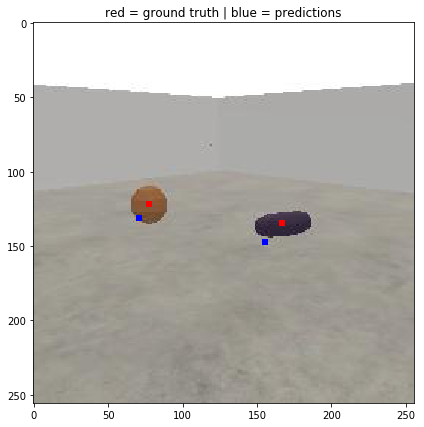

In [6]:
print(data[0]['labels'].shape)
print(data[0]['predictions'].shape)


seq = 0

time_steps = len(data[seq]['labels'])
print(time_steps)
for t in range(time_steps):
    image = data[seq]['images'][t].copy()
    labels = data[seq]['labels'][t] * 256
    predictions = data[seq]['predictions'][t] * 256

    cg = int(255 / time_steps * t)
    image = draw_positions(image, labels, color = [255, 0, 0])
    image = draw_positions(image, predictions, color = [0, 0, 255])
    plt.figure(figsize=(7,7))
    plt.imshow(image)
    ax = plt.title('red = ground truth | blue = predictions')

In [7]:
time_steps = 6
def sequence_to_video(data, seq, output_dir):
    #offset = data[seq]['images'].shape[0]
    offset = 0
    images = data[seq]['images'].copy()
    #bboxes = data[seq]['raw_bboxes']
    for t in range(time_steps):
        labels = data[seq]['labels'][t] * 256
        images[t+offset] = draw_positions(images[t+offset], labels, color = [255, 0, 0])

        predictions = data[seq]['predictions'][t] * 256
        images[t+offset] = draw_positions(images[t+offset], predictions, color = [0, 0, 255])

        #images[t+offset] = draw_bounding_boxes(images[t+offset], bboxes[t])

    video_file = os.path.join(output_dir, str(seq))
    make_videos(np.array(images), video_file, FPS=20)

output_dir = './videos'
for seq in range(len(data)):
    sequence_to_video(data, seq, output_dir)
print('%d videos stored at %s' % (len(data), output_dir))

20 videos stored at ./videos
